# Workshop 03 : Advanced neural networks

In [1]:
import os
import re
import math
from pathlib import Path

In [2]:
import numpy as np
import pandas as pd 

In [3]:
import matplotlib.pyplot as plt 
import matplotlib.image  as mpimg
from   matplotlib        import colors

%matplotlib inline

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D, AvgPool2D, Dropout, UpSampling2D
from tensorflow.keras.models import Sequential, Model

tf.__version__

2024-05-29 01:02:07.676640: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-29 01:02:07.705289: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 01:02:08.179749: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'2.16.1'

## Pre-processing

In [5]:
# When reading the PNG image with 3 channels,
# transparent parts are transformed into black
# However, normally they must be white
# So I assumed that the transparent part is encoded as (0, 0, 0, 0)
# In this case, I transform it to (255, 255, 255)
def rgb_to_rgba(img):
    h, w, c = img.shape
    if c != 4:
        return img
    
    resh_img = img.reshape([-1, c])
    new_img = []
    
    for i in range(len(resh_img)):
        l = resh_img[i, :]
        if l[3] == 0:
            new_img.append([255, 255, 255])
        else:
            new_img.append(l[:-1])
    return np.array(new_img).reshape([h, w, 3])
    
rgb_to_rgba(np.array([
    [[255, 200, 100, 255], [255, 200, 100, 255], [255, 200, 100, 0]],
    [[255, 200, 100, 255], [0, 0, 0, 0], [255, 200, 100, 200]]
]))

array([[[255, 200, 100],
        [255, 200, 100],
        [255, 255, 255]],

       [[255, 200, 100],
        [255, 255, 255],
        [255, 200, 100]]])

In [6]:
DATASET_LOC = 'pokemon/'

types_df = pd.read_csv(DATASET_LOC + 'pokemon.csv')
types_df = types_df.drop(['Type2'], axis=1)

def generate_dataset(ext='*.png'):
    d = DATASET_LOC + 'images'
    path = Path(d)
    files = list(path.glob(ext))
    names = [os.path.split(f)[1] for f in files ]
    image_df = pd.concat([pd.Series(names, name='Name'), pd.Series(files, name='path').astype(str)], axis=1)
    image_df['Name'] = image_df['Name'].apply(lambda x: re.sub(r'\.\w+$', '', x))
    
    df = image_df.merge(types_df, on='Name')
    
    imgs = []
    for index in range(df.shape[0]):
        img = tf.io.decode_image(tf.io.read_file(df['path'][index]), channels=0)
        img = rgb_to_rgba(img.numpy())
        imgs.append(img)
#         imgs.append(mpimg.imread(df['path'][index]))
    
    return np.array(imgs), df['Type1'].values

def show_images(imgs, y, n):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(imgs[i]) # recontruct the matrix
        plt.gray()
        plt.title("T: " + str(y[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
def classify_images(imgs, cls, cls_mdl, n):
    plt.figure(figsize=(20, 4))
    Y_pred = cls_mdl.predict(imgs[0:n])
    for i in range(n):
        # display original
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(imgs[i]) # recontruct the matrix
        plt.gray()
        plt.title("T: " + str(cls[i]) + ', P: ' + str(Y_pred[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
print('All functions have been defined')

All functions have been defined


2024-05-29 01:02:08.573283: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-29 01:02:08.573549: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


(809, 120, 120, 3) (809,)


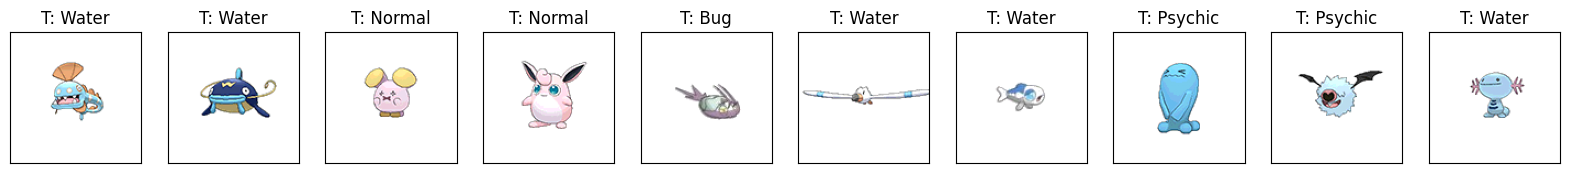

In [7]:
# Dataset
X, Y = generate_dataset()

X = X / 255 # normalizing pixls



# 809 images of 120X120 pixels, each eencoded using 3 chanels 
print(X.shape, Y.shape)

show_images(X, Y, 10)

In [8]:
# train dataset
X_train, Y_train = X[:567, :, :, :], Y[:567]

# test dataset
X_test, Y_test = X[567:, :, :, :], Y[567:]
 
X_train.shape, X_test.shape

((567, 120, 120, 3), (242, 120, 120, 3))

In [9]:
from sklearn.preprocessing import LabelEncoder

pokemon_type_enc = LabelEncoder()

Y_train = pokemon_type_enc.fit_transform(Y_train)
Y_test = pokemon_type_enc.transform(Y_test)

cls_len = len(np.unique(Y_train))

Y_train_onehot = tf.keras.utils.to_categorical(Y_train, cls_len)
Y_test_onehot = tf.keras.utils.to_categorical(Y_test, cls_len)


np.unique(Y_train), np.unique(Y_test)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]))

## 1. Clustering

### 1.1. MLP-based auto-encoder

### 1.2. CNN-based auto-encoder

## 2. Classification

### 2.1. CNN-based classifier

### 2.2. Clustering-based classifier

## 3. Generation

### 3.1. Variational auto-encoder

### 3.2. GAN